# LSTM Autoencoder 
## Tennessee Eastman Process Simulation Dataset

Source: https://www.kaggle.com/datasets/averkij/tennessee-eastman-process-simulation-dataset

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from model.autoencoder import LSTMAutoencoder, LSTMAutoencoderTransformer
from data.process import TEPDataLoader
from data.utils import get_missing_values_table
from data.plot import plot_encoded_variables, plot_simulation_anomalies

import plotly.graph_objects as go
import plotly.express as px 
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from tqdm import tqdm

from sklearn.metrics import accuracy_score

from sklearn import set_config
set_config(display="diagram")

2022-05-17 19:32:05.174483: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-17 19:32:05.174774: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Loading datasets

In [2]:
# create the loader class instance
loader = TEPDataLoader('data/raw')
# load the training dataset
X_train_faulty, X_train_normal = loader.load_training_datasets()

50it [01:15,  1.51s/it]
3it [00:03,  1.32s/it]


## Model Evaluation

The model is trained by running the `train_autoencoder.py` scrip. The notebook will then read the saved models to perform the analysis.

### Autoencoder
#### Training

In [3]:
# Measured process data in the multiphase batch process are usually stored in the form of a three-dimensional cube
# I×J×K, recording K measured points with J process variables of all the I simulations
I = X_train_normal.simulationRun.unique().shape[0]
K = X_train_normal['sample'].unique().shape[0]
J = len(X_train_normal.columns[3:])
print(f'I: {I}, J: {J}, K: {K}')

I: 500, J: 52, K: 500


In [4]:
# load the trained model
model = LSTMAutoencoder('data/models/v0/model_keras.h5')
# import the transformer
transformer = joblib.load('data/models/v0/transformer.pkl')
# define constants
window = 1
# create the datasets
X_train_transf = transformer.transform(X_train_normal)
# create the training dataset
X_train_windowed = LSTMAutoencoder.created_windowed_dataset(X_train_transf, window=window, batch_size=K)

2022-05-17 19:33:36.474042: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-17 19:33:36.474101: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-17 19:33:36.474125: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-6SCUR4F): /proc/driver/nvidia/version does not exist
2022-05-17 19:33:36.474504: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Validation
First let's have a look at the training history. Notice that the model tents to reduce its generalization capabilities as the number of epochs increase. Looking at the chart, it is possible to notice that 30 epochs yields the best balance between training and validation loss.

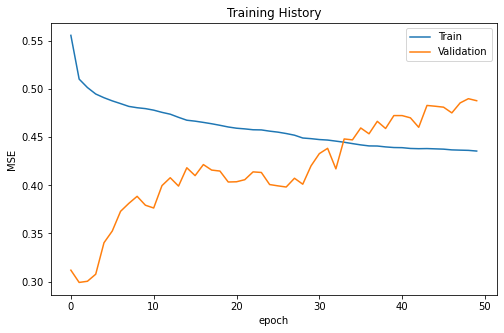

In [5]:
# plot the loss per training epoch
model.plot_history()

Next, let's plot how the reconstruction looks like.

In [6]:
def inverse_transform(X, batch_size=K, window=window, transformer=None):
    if(transformer is not None):
        return transformer.inverse_transform(LSTMAutoencoder.reverse_windowed_dataset(X, batch_size, window))
    return LSTMAutoencoder.reverse_windowed_dataset(X, batch_size, window)
# calculate the predictions
X_pred = model.predict(X_train_windowed)
X_train_pred = pd.DataFrame(inverse_transform(X_pred), columns=transformer.selected_columns)

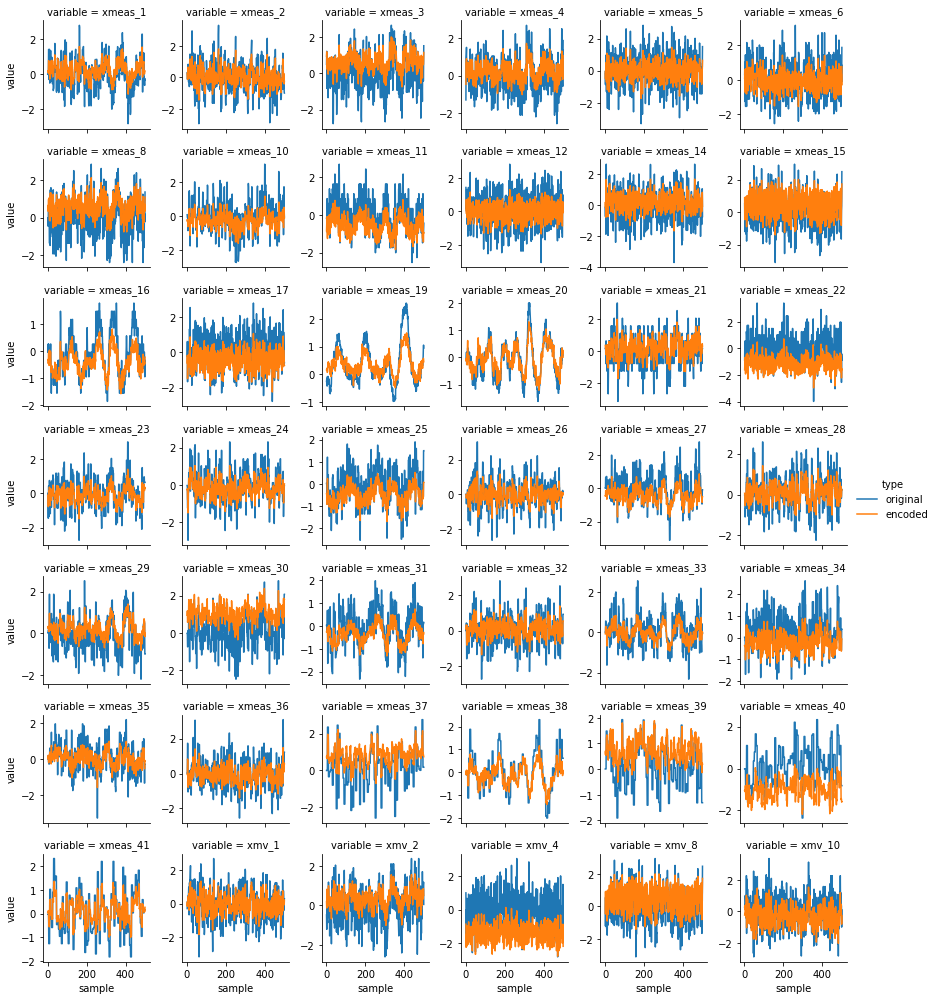

In [7]:
# plot the comparison between acatual and encoded signals
X_train_transf = pd.DataFrame(X_train_transf, columns=transformer.selected_columns)
X_train_transf['faultNumber'] = X_train_normal.faultNumber.values
X_train_transf['simulationRun'] = X_train_normal.simulationRun.values
X_train_transf['sample'] = X_train_normal['sample'].values

X_train_pred['faultNumber'] = X_train_normal.faultNumber.values
X_train_pred['simulationRun'] = X_train_normal.simulationRun.values
X_train_pred['sample'] = X_train_normal['sample'].values

plot_encoded_variables(X_train_transf, X_train_pred, transformer.selected_columns,  1)

#### Test dataset

Initially, the final version of the model is loaded, obtained for 30 epochs of training time. Next, the test dataset is loaded and the reconstruction error is evaluated.

In [8]:
# load the trained model
model = LSTMAutoencoder('data/models/final/model_keras.h5')
# import the transformer
transformer = joblib.load('data/models/final/transformer.pkl')

In [9]:
X_test_normal = loader._load('fault_free_testing.csv')

5it [00:07,  1.40s/it]


In [10]:
# define constants
window = 1
# create the datasets
X_test_transf = transformer.transform(X_test_normal)
# create the training dataset
K_test = X_test_normal['sample'].unique().shape[0]
X_test_windowed = LSTMAutoencoder.created_windowed_dataset(X_test_transf, window=window, batch_size=K_test)

In [11]:
# calculate the predictions
X_pred = model.predict(X_test_windowed)
X_test_pred = pd.DataFrame(inverse_transform(X_pred), columns=transformer.selected_columns)

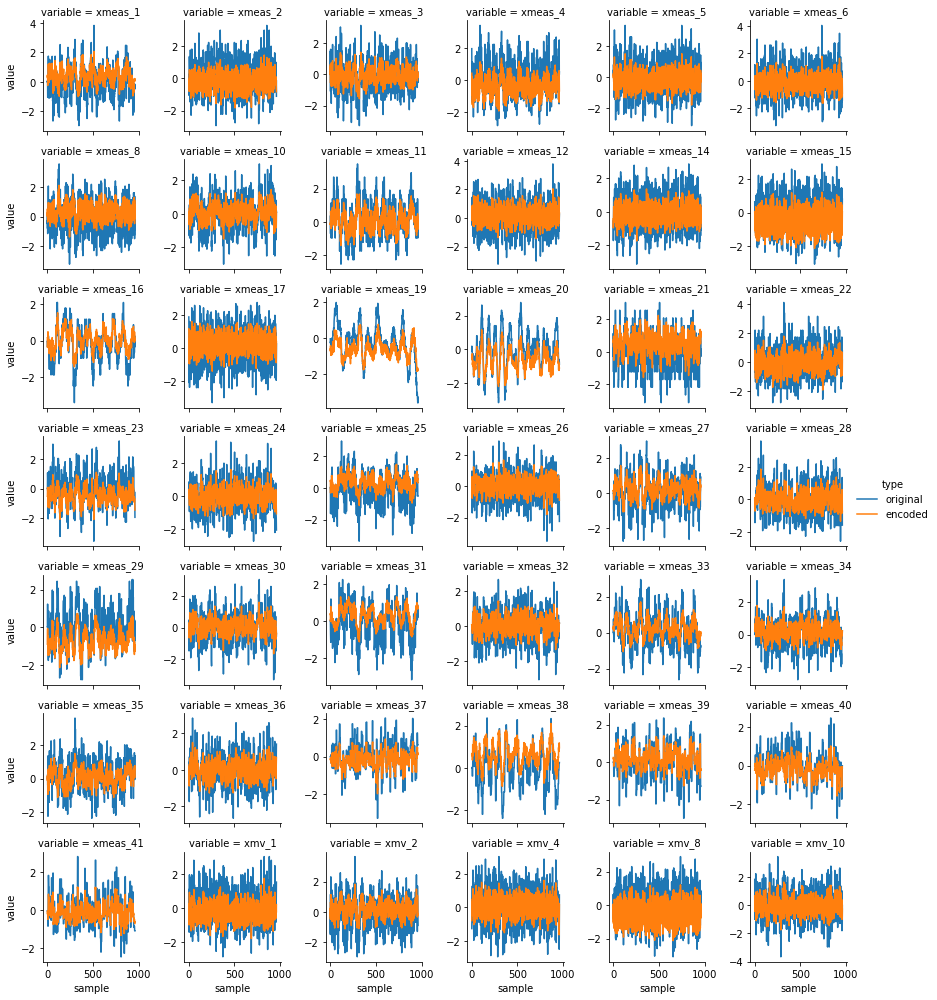

In [12]:
# plot the comparison between acatual and encoded signals
X_test_transf = pd.DataFrame(X_test_transf, columns=transformer.selected_columns)
X_test_transf['faultNumber'] = X_test_normal.faultNumber.values
X_test_transf['simulationRun'] = X_test_normal.simulationRun.values
X_test_transf['sample'] = X_test_normal['sample'].values

X_test_pred['faultNumber'] = X_test_normal.faultNumber.values
X_test_pred['simulationRun'] = X_test_normal.simulationRun.values
X_test_pred['sample'] = X_test_normal['sample'].values

plot_encoded_variables(X_test_transf, X_test_pred, transformer.selected_columns,  1)

Finally, let's have a look at the reconstruction error between the training and test normal datasets. Notice that the distribution of the error remais the same, meaning the model was able to generalize for the training and test datasets.

/home/victor/miniconda3/envs/dev-udacity-capstone/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


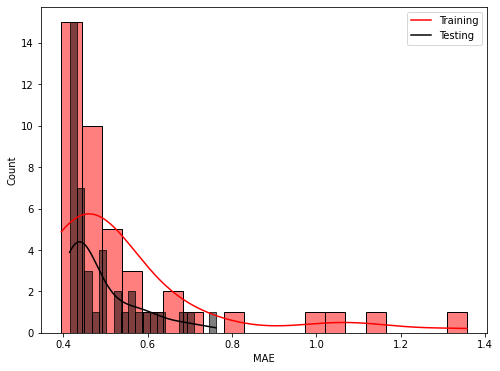

In [13]:
train_loss_mae = np.mean(np.abs(X_train_pred - X_train_transf))
test_loss_mae = np.mean(np.abs(X_test_pred - X_test_transf))
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(x=train_loss_mae[:-3], kde=True, bins=20, color='red')
sns.histplot(x=test_loss_mae[:-3], kde=True, bins=20, color='black')
ax.set_xlabel('MAE')
ax.legend(['Training', 'Testing'])

### Anomaly Detection

Given the autoencoder learned what the normal operation should look like, how can we detect that the process is in an anomalous state? In order to do that, the following procedure is proposed:
1. Estimate the maximum reconstruction error distribution from the training dataset
2. For a faulty signal, estimate the reconstruciton error at each sample
   1. Check if the error is within 1 std for every variable
   2. If outside the range, record the step the anomaly was detected

From the previous analysis, we can use the 99th percentile for the calculated MAE.

In [14]:
threshold = np.percentile(train_loss_mae, 99)
print('The 99th percentile of the training MAE is:', threshold)

The 99th percentile of the training MAE is: 1.2609543704986577


With the given error distribution, the next step is to reconstruct a fautly signal and identify where the limites are violated. Initially, let's have a look at the first type of fault available in the training dataset.

In [15]:
# sample fault
fault_num = 1
X_fault_sample = X_train_faulty.loc[X_train_faulty.faultNumber == fault_num]
# create the datasets
X_train_faulty_transf = transformer.transform(X_fault_sample)
# create the training dataset
X_train_faulty_windowed = LSTMAutoencoder.created_windowed_dataset(X_train_faulty_transf, window=window, batch_size=K)
# predict each signal
X_pred_train_faulty = pd.DataFrame(inverse_transform(model.predict(X_train_faulty_windowed)), columns=transformer.selected_columns)

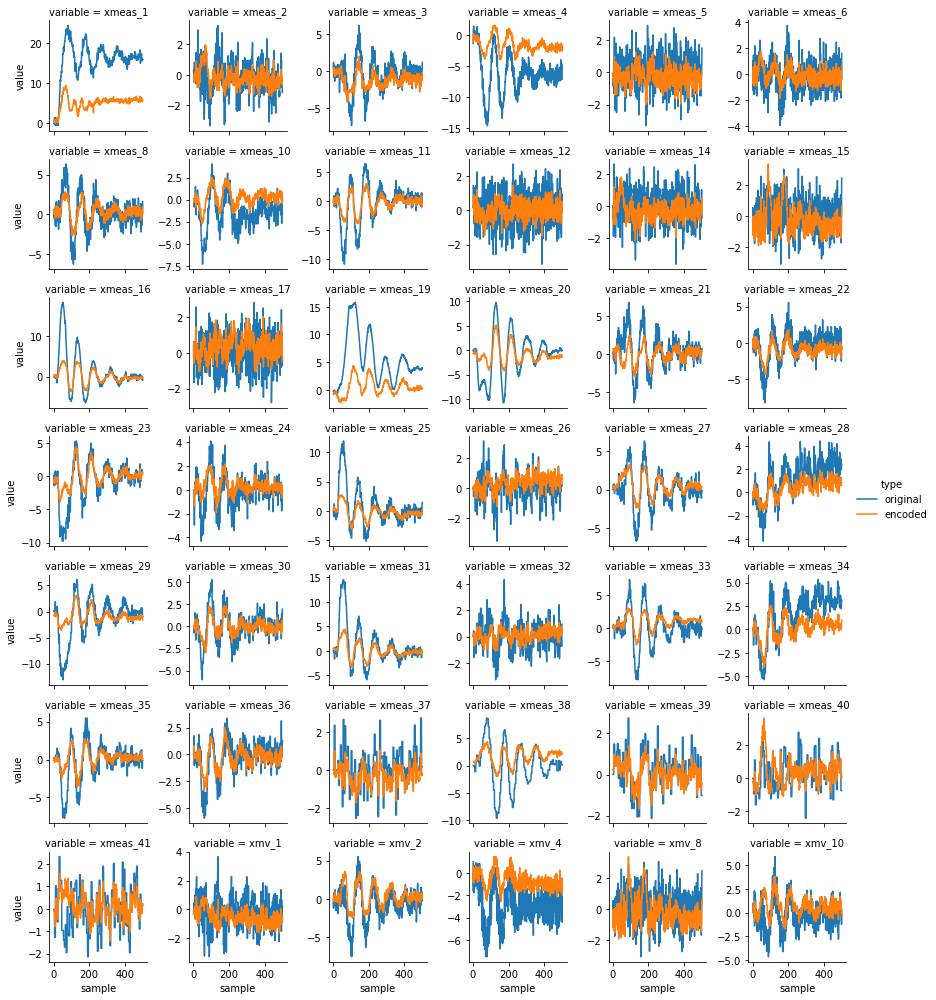

In [16]:
X_train_faulty_transf = pd.DataFrame(X_train_faulty_transf, columns=transformer.selected_columns)
X_train_faulty_transf['faultNumber'] = X_fault_sample.faultNumber.values
X_train_faulty_transf['simulationRun'] = X_fault_sample.simulationRun.values
X_train_faulty_transf['sample'] = X_fault_sample['sample'].values

X_pred_train_faulty['faultNumber'] = X_fault_sample.faultNumber.values
X_pred_train_faulty['simulationRun'] = X_fault_sample.simulationRun.values
X_pred_train_faulty['sample'] = X_fault_sample['sample'].values

plot_encoded_variables(X_train_faulty_transf, X_pred_train_faulty, transformer.selected_columns, 1, fault_num)

In [17]:
# estimate the MAE for each sample
X_pred_train_faulty['loss_mae'] = np.mean(np.abs(X_pred_train_faulty - X_train_faulty_transf), axis=1)

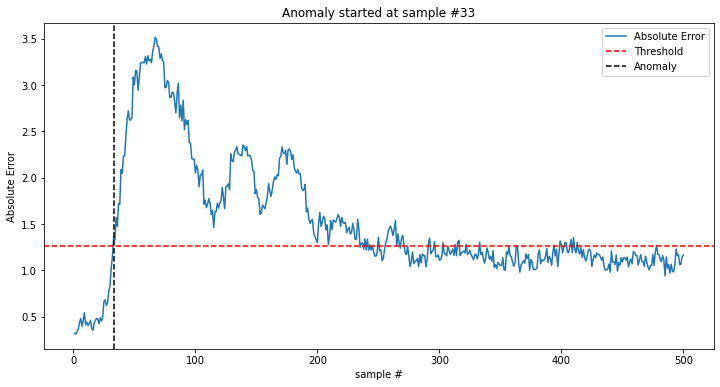

In [26]:
# plot the anomaly location
plot_simulation_anomalies(X_pred_train_faulty, 50, threshold)

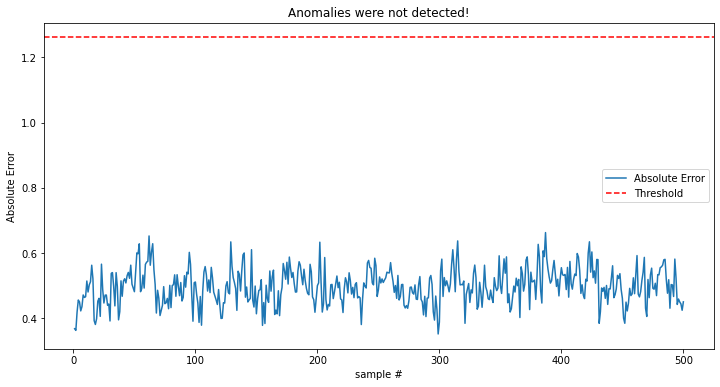

In [19]:
X_train_pred['loss_mae'] = np.mean(np.abs(X_train_pred - X_train_transf), axis=1)
plot_simulation_anomalies(X_train_pred, 1, threshold)

Great! The autoencoder was able to detect an anomaly at the 34th sample. If we look at the dataset description, it is described that the faults were introduced at 1 hour operation. Given that each sample is at 3 minutes, it happens at 102 minutes, which is not so close to 100 minutes! Therefore, the threshold selected appears is already close, but needs fine tuning.

Next, let's validate if the same holds for all the simulations for fault type #1.

In [ ]:
simulation_failures = []
percentiles = [65, 70, 75, 80, 85, 90, 95, 99]
for simulation_run, df_sim in X_pred_train_faulty.groupby('simulationRun'):
    for percentile in percentiles:
        failure_index = df_sim[df_sim['loss_mae']>np.percentile(train_loss_mae, percentile)]['sample'].values[0]
        simulation_failures.append((simulation_run, percentile, failure_index, failure_index*3))

simulation_failures = pd.DataFrame(simulation_failures, columns=['simulationRun', 'percentile' ,'failure_index', 'failure_time'])

Text(0.5, 0, 'Failure Time (min)')

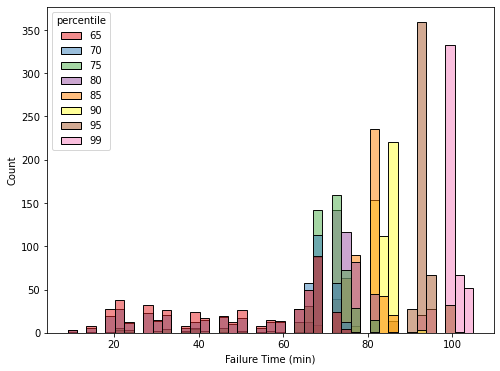

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(simulation_failures, x='failure_time', hue='percentile', ax=ax, palette='Set1')
ax.set_xlabel('Failure Time (min)')

### Accuracy

Now, using the previous rule let's evaluate the accuracy of the system.

In [61]:
def predict_anomalies(X, model, transformer, threshold, batch_size):
    simulation_failures = []
    for (fault_number, simulation_run), df_sim in tqdm(X.groupby(['faultNumber','simulationRun'])):
        X_transf = transformer.transform(df_sim)
        # create the training dataset
        X_windowed = LSTMAutoencoder.created_windowed_dataset(X_transf, window=window, batch_size=batch_size)
        # predict each signal
        X_pred = pd.DataFrame(inverse_transform(model.predict(X_windowed), batch_size=batch_size), columns=transformer.selected_columns)
        X_transf = pd.DataFrame(X_transf, columns=transformer.selected_columns) 
        loss_mae = np.mean(np.abs(X_pred - X_transf), axis=1)
        
        failure_index = df_sim.reset_index().loc[loss_mae>threshold]['sample']
        if(len(failure_index)>0):
            idx = failure_index.values[0]
            simulation_failures.append((fault_number, simulation_run, idx, idx*3, True))
        else:
            simulation_failures.append((fault_number, simulation_run, np.nan, np.nan, False))
        
    simulation_failures = pd.DataFrame(simulation_failures, columns=['failureType','simulationRun', 'failure_index', 'failure_time','anomaly'])
    return simulation_failures

In [ ]:
display(predict_anomalies(X_train_normal.loc[X_train_normal.simulationRun.isin(list(range(10)))], model, transformer, threshold, K))
display(predict_anomalies(X_train_faulty.loc[X_train_faulty.simulationRun.isin(list(range(10)))], model, transformer, threshold, K))

#### Predict anomalies for all the faults

In [ ]:
X_test_faulty = loader._load('faulty_testing.csv')

In [ ]:
failures_train_faulty = predict_anomalies(X_train_faulty, model, transformer, threshold, K)
failures_test_faulty = predict_anomalies(X_test_faulty, model, transformer, threshold, K_test)

In [ ]:
failures_train_faulty['ground_truth'] = False
failures_test_faulty['ground_truth'] = False

#### Predict anomalies for all the normal signals

In [55]:
failures_train_normal = predict_anomalies(X_train_normal, model, transformer, threshold, K)
failures_test_normal = predict_anomalies(X_test_normal, model, transformer, threshold, K_test)

100%|██████████| 500/500 [01:00<00:00,  8.22it/s]


In [56]:
failures_test_normal['ground_truth'] = False
failures_train_normal['ground_truth'] = False

In [1]:
accuracy_score(failures_test_normal.ground_truth, failures_test_normal.anomaly)
accuracy_score(failures_train_normal.ground_truth, failures_train_normal.anomaly)

NameError: name 'accuracy_score' is not defined

## References
* https://towardsdatascience.com/lstm-autoencoder-for-anomaly-detection-e1f4f2ee7ccf
* https://machinelearningmastery.com/lstm-autoencoders/